# Error Plot for JCPexample6

## Steady Flow Past Disk

### Import Stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import DRLPDE_nn
import DRLPDE_param_solver
import DRLPDE_functions.DefineDomain
import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

### Define Variables

In [2]:
### Domain Parameters

velocity_vtk = 'Steady_FlowPastDisk_u_1_765'
pressure_vtk = 'Steady_FlowPastDisk_p_1_765'

### Domain Parameters
dim = 2

L_right = 2.5
L_left = 0
L_height = L_right/5
R = L_height/3

circle_centre = [L_height,0]

######################## Plotting and Error Parameters ########################
numpts_x = 257
numpts_y =  129

x1g, x2g = torch.meshgrid([torch.linspace(L_left,L_right,numpts_x),
                              torch.linspace(-L_height,L_height,numpts_y)])

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1)], dim=-1).requires_grad_(True)

integral_factor = ((L_right - L_left)/(numpts_x-1))*((2*L_height)/(numpts_y-1))

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()

C:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
### Load the IBM model
Nx = 256 # Number of points along x-axis - Does not count end point
Ny = 160 # Number of points along y-axis - Does not count end point
N_channel = 128
num_files = 100

data_vel = np.loadtxt('tools/vtk_files/' + velocity_vtk + '.vtk').reshape((Nx*Ny,3))

IBM_U = np.transpose( data_vel[:,0].reshape(Ny,Nx) )
IBM_V = np.transpose( data_vel[:,1].reshape(Ny,Nx) )
IBM_P = np.transpose( np.loadtxt('tools/vtk_files/' + pressure_vtk + '.vtk') )

### Restrict to values in the pipe
IBM_U = IBM_U[:, 16:N_channel + 16 + 1]
IBM_V = IBM_V[:, 16:N_channel + 16 + 1]
IBM_P = IBM_P[:, 16:N_channel + 16 + 1]

IBM_U = np.concatenate( (IBM_U, IBM_U[0,None,:]), axis=0)
IBM_V = np.concatenate( (IBM_V, IBM_V[0,None,:]), axis=0)
IBM_P = np.concatenate( (IBM_P, IBM_V[0,None,:]), axis=0)

In [31]:
### Load Trained model
loadmodel = 'JCPexample6'
model_vel = torch.load("savedmodels/" + loadmodel + ".pt").to('cpu')
model_pressure = torch.load("savedmodels/" + 'pressure_test' + ".pt").to('cpu')

Trained_Vel = model_vel(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()
Trained_Vel_U = Trained_Vel[:,:,0]
Trained_Vel_V = Trained_Vel[:,:,1] 

Trained_Pressure = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

In [32]:
### Velocity Errors

L2_error_U =  np.sum( ( (Trained_Vel_U - IBM_U)**2 )*integral_factor)
L2_error_V =  np.sum( ( (Trained_Vel_V - IBM_V)**2 )*integral_factor)

Linf_error_U = np.amax(np.abs(Trained_Vel_U - IBM_U))
Linf_error_V = np.amax(np.abs(Trained_Vel_V - IBM_V))

L2_error = np.sqrt( L2_error_U + L2_error_V )
Linf_error = np.amax( [Linf_error_U, Linf_error_V])

### Pressure Errors
L2_error_P =  np.sum( ( (Trained_Pressure - IBM_P)**2 )*integral_factor)
Linf_error_P = np.amax(np.abs(Trained_Pressure - IBM_P))

### Normalize

L2_norm_IBM_U = np.sum( (( IBM_U )**2)*integral_factor )
L2_norm_IBM_V = np.sum( (( IBM_V )**2)*integral_factor )
L2_norm_IBM = np.sqrt(L2_norm_IBM_U + L2_norm_IBM_V)
Linf_norm_IBM = np.amax( [np.amax( np.abs(IBM_U)), np.amax( np.abs(IBM_V))] )

L2_norm_IBM_P = np.sqrt( np.sum( (( IBM_P )**2)*integral_factor ) )
Linf_norm_IBM_P = np.amax(np.abs(IBM_P) )

print('L2_error of velocity = {:.5f}'.format(L2_error))
print('Linf_error of velocity = {:.5f}'.format(Linf_error))

print('L2_error of pressure = {:.5f}'.format(L2_error_P))
print('Linf_error of pressure = {:.5f}'.format(Linf_error_P))

print('Relative L2_error of velocity = {:.5f}'.format(L2_error/L2_norm_IBM))
print('Relative Linf_error of velocity = {:.5f}'.format(Linf_error/Linf_norm_IBM))

print('Relative L2_error of pressure = {:.5f}'.format(L2_error_P/L2_norm_IBM_P))
print('Relative Linf_error of pressure = {:.5f}'.format(Linf_error_P/Linf_norm_IBM_P))


L2_error of velocity = 0.21071
Linf_error of velocity = 0.91642
L2_error of pressure = 132542.72516
Linf_error of pressure = 329.53933
Relative L2_error of velocity = 0.10013
Relative Linf_error of velocity = 0.35640
Relative L2_error of pressure = 2111.40760
Relative Linf_error of pressure = 2.53398


## Plot Some Contours

Max entrance velocity of Trained = 1.7445
Max entrance velocity of IBM = 1.7649


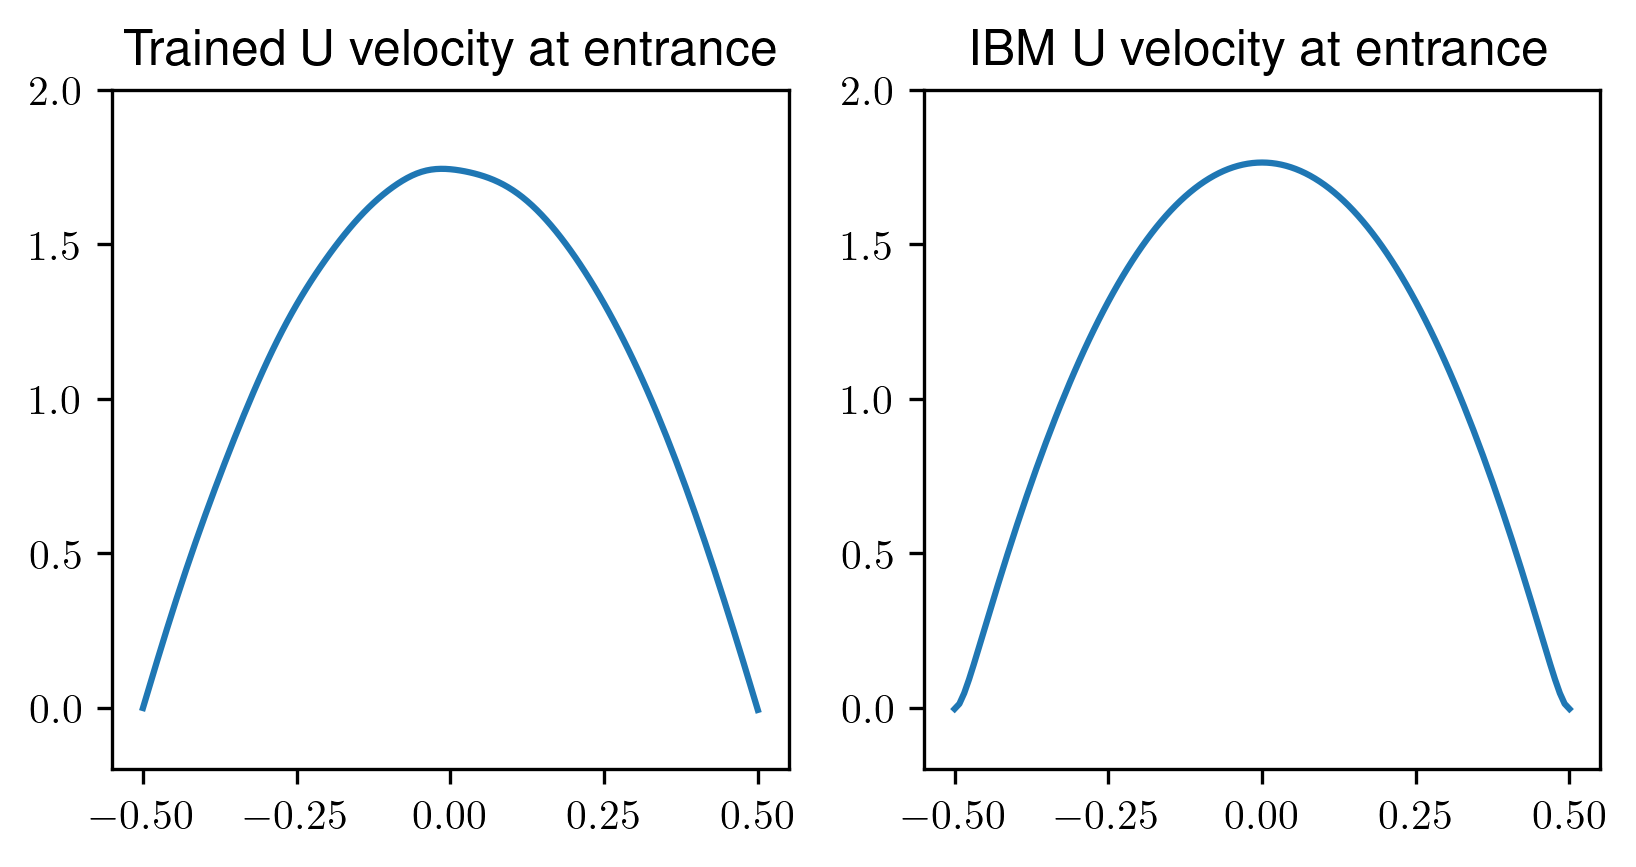

In [33]:
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.4, 3))

wall = np.linspace(-L_height, L_height, numpts_y)

#fig.suptitle('Comparison of Flow Past Disk', fontsize=20)

ax[0].plot(wall, Trained_Vel_U[0,:])
ax[0].set_ylim(-0.2, 2)
ax[0].set_title('Trained U velocity at entrance')

ax[1].plot(wall, IBM_U[0,:])
ax[1].set_ylim(-0.2, 2)
ax[1].set_title('IBM U velocity at entrance')

print('Max entrance velocity of Trained = {:.4f}'.format(np.max(Trained_Vel_U[0,:])))
print('Max entrance velocity of IBM = {:.4f}'.format(np.max(IBM_U[0,:])))

### Plot Full

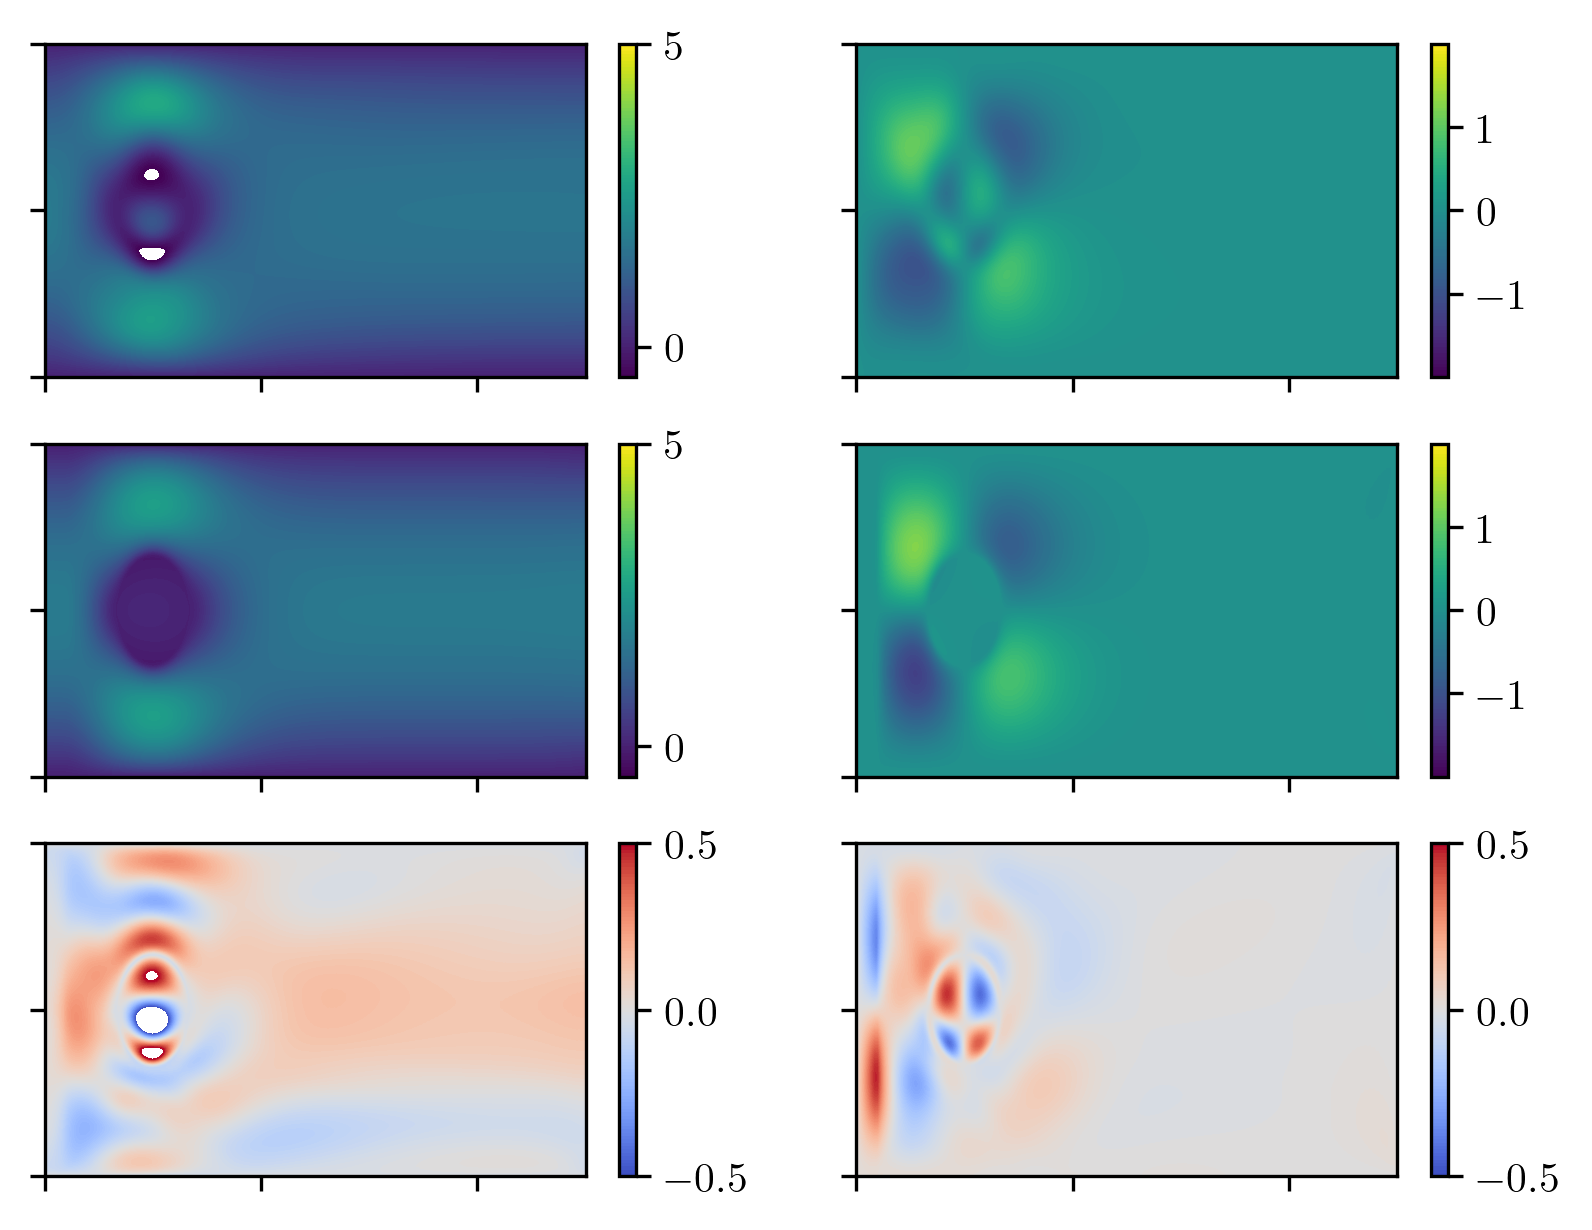

In [34]:
### Plotting
 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

levels_flow_1 = np.linspace(-0.5, 5, 100)
levels_tick_1 = np.linspace(0, 5, 2)

levels_flow_2 = np.linspace(-2, 2, 100)
levels_tick_2 = [-1, 0, 1]

error_levels = np.linspace(-0.5, 0.5, 100)
error_tick = np.linspace(-0.5, 0.5 ,3)

plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=[6.4, 5.0])

contour0 = ax[0,0].contourf(x1plot, x2plot, Trained_Vel_U, levels_flow_1, cmap=plt.cm.viridis)
#ax[0,0].set_title(r'Neural Network Approximation of $u_1$ velocity')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
plt.colorbar(contour0, ticks =levels_tick_1, ax=ax[0,0])

contour1 = ax[1,0].contourf(x1plot, x2plot, IBM_U, levels_flow_1, cmap=plt.cm.viridis)
#ax[1,0].set_title(r'IBM Solution of $u_1$')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
plt.colorbar(contour1, ticks =levels_tick_1, ax=ax[1,0])

contour2 = ax[2,0].contourf(x1plot, x2plot, IBM_U - Trained_Vel_U, levels=error_levels, cmap=plt.cm.coolwarm)
#ax[2,0].set_title(r'Difference between IBM and Neural Network of $u_1$')
ax[2,0].set_xticklabels([])
ax[2,0].set_yticklabels([])
plt.colorbar(contour2, ticks =error_tick, ax=ax[2,0])

contour3 = ax[0,1].contourf(x1plot, x2plot, Trained_Vel_V, levels_flow_2, cmap=plt.cm.viridis)
#ax[0,1].set_title(r'Neural Network Approximation of $u_2$ velocity')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
plt.colorbar(contour3, ticks =levels_tick_2, ax=ax[0,1])

contour4 = ax[1,1].contourf(x1plot, x2plot, IBM_V, levels_flow_2, cmap=plt.cm.viridis)
#ax[1,1].set_title(r'IBM Solution of $u_2$')
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
plt.colorbar(contour3, ticks =levels_tick_2, ax=ax[1,1])

contour5 = ax[2,1].contourf(x1plot, x2plot, IBM_V - Trained_Vel_V, levels=error_levels, cmap=plt.cm.coolwarm)
#ax[2,1].set_title(r'Difference between IBM and Neural Network of $u_2$')
ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
plt.colorbar(contour5, ticks =error_tick, ax=ax[2,1])

#plt.tight_layout(pad=5.0)

#fig.savefig('images/JCPexample6', facecolor='w', transparent=False)

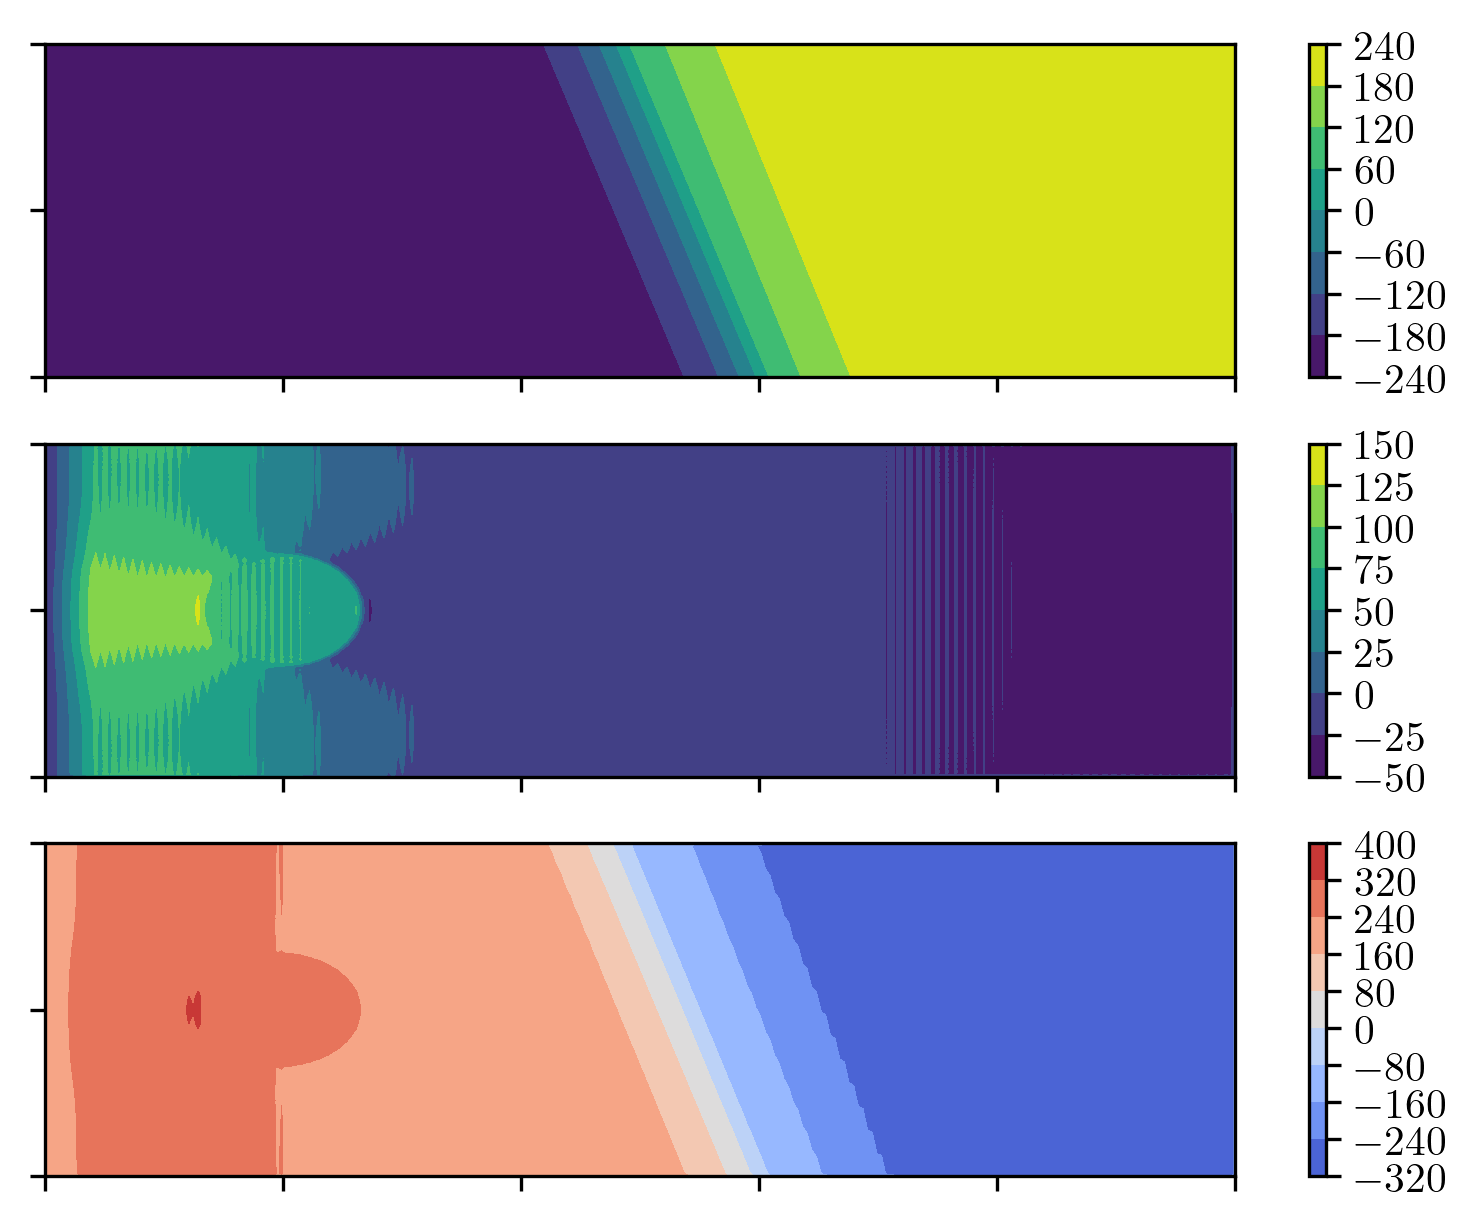

In [30]:
plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[6.4, 5.0])

contour0 = ax[0].contourf(x1plot, x2plot, Trained_Pressure, cmap=plt.cm.viridis)
ax[0].set_title(r'Trained Pressure')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
plt.colorbar(contour0, ax=ax[0])

contour1 = ax[1].contourf(x1plot, x2plot, IBM_P, cmap=plt.cm.viridis)
ax[1].set_title(r'IBM Pressure')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
plt.colorbar(contour1, ax=ax[1])

contour2 = ax[2].contourf(x1plot, x2plot, IBM_P - Trained_Pressure, cmap=plt.cm.coolwarm)
ax[2].set_title(r'Difference between IBM and Trained Pressure')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
plt.colorbar(contour2, ax=ax[2])